In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('RSCCASN.csv', index_col='DATE', parse_dates=True)

In [ ]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


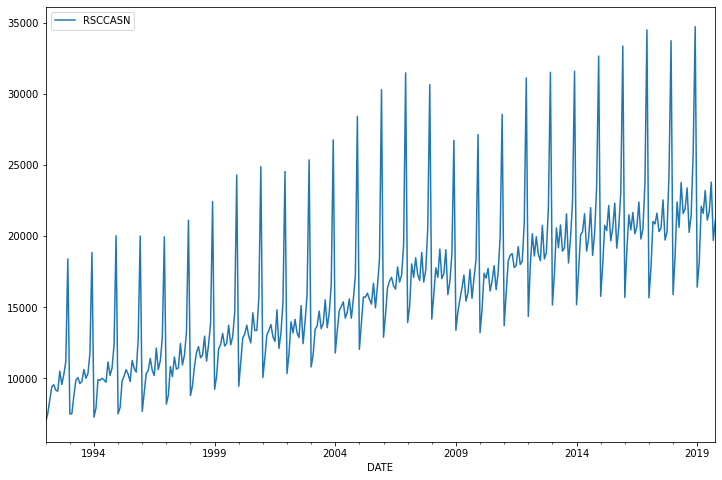

In [ ]:
df.plot(figsize = (12,8))

In [ ]:
test_split_length = 18
train_splt_length = len(df) - test_split_length

In [ ]:
train = df.iloc[0:train_splt_length]
test = df.iloc[train_splt_length:]
print(len(train), type(train))
print(len(test), type(train))

316 <class 'pandas.core.frame.DataFrame'>
18 <class 'pandas.core.frame.DataFrame'>


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
print(np.max(scaled_train), np.min(scaled_train), np.max(scaled_test), np.min(scaled_test))
print(scaled_train.shape, scaled_test.shape)

1.0 0.0 1.0081324426372351 0.3438861458030787
(316, 1) (18, 1)


In [ ]:
import tensorflow as tf

In [ ]:
length = 12 # number of inputs in each batch. i.e., length of batch
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_train, scaled_train,
                                                                length=length, batch_size=1)

In [ ]:
print(len(generator))

304


In [ ]:
X,y = generator[0]
print('each input and output shape in generator is:')
print(X.shape)
print(y.shape)

each input and output shape in generator is:
(1, 12, 1)
(1, 1)


In [ ]:
#Build model and evaluate results and plot outputs to compare real value and predicted value

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [ ]:
length = 12 # taken from initialization for creating generator
n_features = 1 #since we are only using one feature for prediction which is sine value

In [ ]:
model = Sequential()

model.add(LSTM(100, activation = 'relu', input_shape=(length,n_features)))
#model.add(Dropout(0.2))

#model.add(LSTM(50))
#model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#define callbacks as LSTMs usually take longer time to train

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [ ]:
#generate validation data to pass to model

In [ ]:
validation_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_test, scaled_test,
                                                                           length=length,batch_size=1)

In [ ]:
model.fit_generator(generator, epochs=20,callbacks=[early_stop],validation_data=validation_generator)

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


304/304 [==============================] - 4s 8ms/step - loss: 0.0456 - val_loss: 0.0078
Epoch 2/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0154 - val_loss: 0.0032
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0158 - val_loss: 0.0033
Epoch 4/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0037 - val_loss: 0.0037


In [ ]:
losses = model.history.history
losses

{'loss': [0.027068302035331726,
  0.0159931518137455,
  0.009199160151183605,
  0.005156107246875763],
 'val_loss': [0.007800620049238205,
  0.0031609071884304285,
  0.0032758943270891905,
  0.003677179804071784]}

In [ ]:
losses = pd.DataFrame(data=losses) #or we can combime above step here directly: pd.DataFrame(model.history.history)

In [ ]:
print(losses)

       loss  val_loss
0  0.027068  0.007801
1  0.015993  0.003161
2  0.009199  0.003276
3  0.005156  0.003677


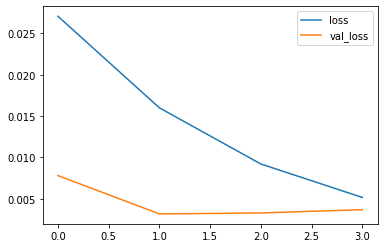

In [ ]:
losses.plot()

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1,length, n_features)

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [ ]:
test_predictions

[array([0.5647422], dtype=float32),
 array([0.53949106], dtype=float32),
 array([0.54807085], dtype=float32),
 array([0.5966318], dtype=float32),
 array([0.5372062], dtype=float32),
 array([0.55598307], dtype=float32),
 array([0.68919635], dtype=float32),
 array([0.9832628], dtype=float32),
 array([0.44694194], dtype=float32),
 array([0.50607306], dtype=float32),
 array([0.5967988], dtype=float32),
 array([0.5604835], dtype=float32),
 array([0.60882455], dtype=float32),
 array([0.59580415], dtype=float32),
 array([0.60549533], dtype=float32),
 array([0.6419963], dtype=float32),
 array([0.6038775], dtype=float32),
 array([0.62187153], dtype=float32)]

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['true_predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,RSCCASN,true_predictions
DATE,,
2018-05-01,23764,22493.259364
2018-06-01,21589,21797.741685
2018-07-01,21919,22034.063437
2018-08-01,23381,23371.626987
2018-09-01,20260,21734.806828
2018-10-01,21473,22251.997585
2018-11-01,25831,25921.224215
2018-12-01,34706,34020.989939
2019-01-01,16410,19248.568850


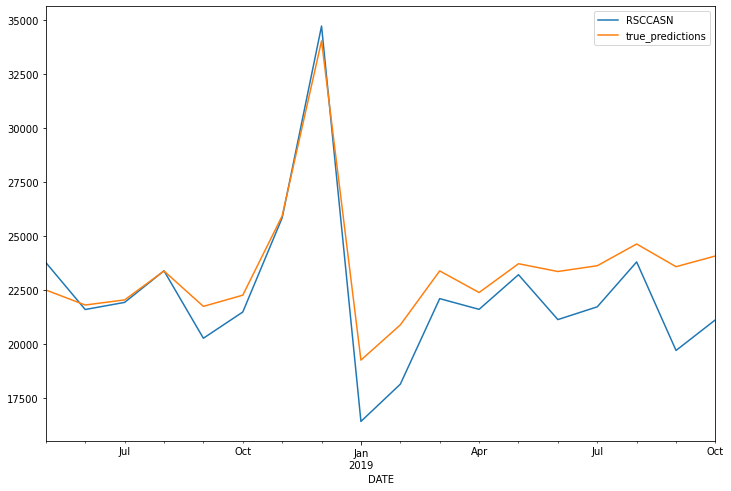

In [ ]:
test.plot(figsize = (12,8))

In [ ]:
#forecast into future

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
print(scaled_full_data.shape)

(334, 1)


In [ ]:
forecast = []
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)
period = 12

for i in range(period):
  current_pred = model.predict(current_batch)[0]
  forecast.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis =1)

In [ ]:
forecast = full_scaler.inverse_transform(forecast)

In [ ]:
forecast_index = pd.date_range(start='2019-11-01',periods=12, freq='MS')

In [ ]:
forecast_df = pd.DataFrame(forecast,index=forecast_index,columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-11-01,26848.907469
2019-12-01,35222.312309
2020-01-01,19455.543836
2020-02-01,20595.606076
2020-03-01,23138.637681
2020-04-01,22969.143673
2020-05-01,24147.508278
2020-06-01,22877.169667
2020-07-01,23369.411831
2020-08-01,24868.821494


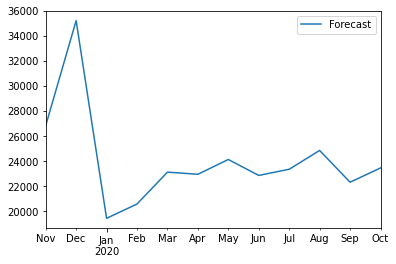

In [ ]:
forecast_df.plot()

(576.0, 611.0)

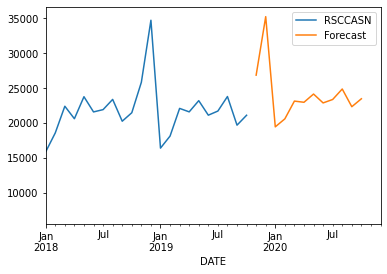

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01') #zoom in